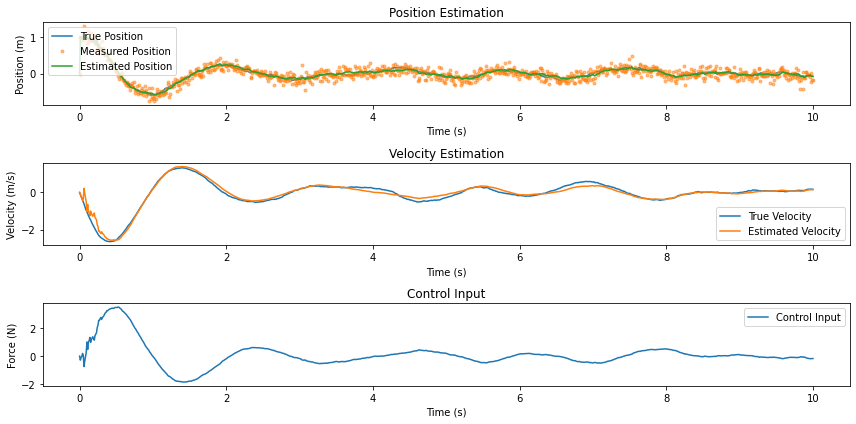

In [11]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

# Define system parameters
m = 1.0    # Mass (kg)
k = 10.0    # Spring constant (N/m)
c = 0.01    # Damping coefficient (Ns/m)
dt = 0.01  # Time step (s)

# State-space matrices (continuous time)
A = np.array([[0, 1],
              [-k/m, -c/m]])
B = np.array([[0],
              [1/m]])
C = np.array([[1, 0]])
D = np.array([[0]])

# Discretize the system
Ad = la.expm(A * dt)
Bd = la.solve(A, (Ad - np.eye(2)) @ B)

# Process and measurement noise covariance
Q = np.array([[1e-4, 0],    # Process noise covariance
              [0, 1e-4]])
R = np.array([[1e-2]])      # Measurement noise covariance

# Kalman filter initialization
P = np.eye(2)               # Initial error covariance
x_hat = np.zeros((2, 1))    # Initial state estimate

# LQR design
Q_x = np.diag([1, 0.1])     # State weighting matrix
R_u = np.array([[0.1]])     # Control weighting matrix

# Solve the Discrete Algebraic Riccati Equation (DARE)
P_lqr = la.solve_discrete_are(Ad, Bd, Q_x, R_u)
K_lqr = np.linalg.inv(R_u + Bd.T @ P_lqr @ Bd) @ (Bd.T @ P_lqr @ Ad)

# Simulation parameters
t_sim = 10  # Simulation time (seconds)
N = int(t_sim / dt)  # Number of time steps
x_true = np.zeros((2, N))  # True states
x_est = np.zeros((2, N))   # Estimated states
y_meas = np.zeros(N)       # Measurements
u = np.zeros(N)            # Control inputs

# Initial state
x_true[:, 0] = [1.0, 0.0]  # Initial position and velocity

# Simulation loop
for k in range(1, N):
    # True system dynamics
    w = np.random.multivariate_normal([0, 0], Q).reshape(-1, 1)  # Process noise
    x_true[:, k] = (Ad @ x_true[:, k-1].reshape(-1, 1) + Bd * u[k-1] + w).flatten()
    y_meas[k] = C @ x_true[:, k].reshape(-1, 1) + np.random.normal(0, np.sqrt(R))

    # Kalman filter prediction
    x_hat = Ad @ x_hat + Bd * u[k-1]
    P = Ad @ P @ Ad.T + Q

    # Kalman filter update
    K_kalman = P @ C.T @ np.linalg.inv(C @ P @ C.T + R)
    x_hat = x_hat + K_kalman @ (y_meas[k] - C @ x_hat)
    P = (np.eye(2) - K_kalman @ C) @ P
    
    # Store estimated state
    x_est[:, k] = x_hat.flatten()

    # LQG control
    u[k] = -K_lqr @ x_hat

# Plot results
time = np.linspace(0, t_sim, N)
plt.figure(figsize=(12, 6))

# Position plot
plt.subplot(3, 1, 1)
plt.plot(time, x_true[0, :], label="True Position")
plt.plot(time, y_meas, '.', label="Measured Position", alpha=0.5)
plt.plot(time, x_est[0, :], label="Estimated Position")
plt.title("Position Estimation")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.legend()

# Velocity plot
plt.subplot(3, 1, 2)
plt.plot(time, x_true[1, :], label="True Velocity")
plt.plot(time, x_est[1, :], label="Estimated Velocity")
plt.title("Velocity Estimation")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend()

# Control plot
plt.subplot(3, 1, 3)
plt.plot(time, u, label="Control Input")
plt.title("Control Input")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.legend()

plt.tight_layout()
plt.show()
